In [1]:
%load_ext autoreload
%autoreload 2

import src.ksd.models as models
from src.ksd.find_modes import find_modes, pairwise_directions, run_bfgs
from src.ksd.langevin import RandomWalkMH, RandomWalkBarker
import src.ksd.langevin as mcmc
from src.ksd.ksd import KSD, SDEKSD, GKSD
from src.ksd.kernel import IMQ
from src.ksd.bootstrap import Bootstrap
from src.ksd.find_modes import find_modes, pairwise_directions
from tqdm.notebook import tqdm, trange

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns

import src.kgof.density as density
import src.kgof.data as data

MCMCKernel = RandomWalkMH # RandomWalkBarker

In [2]:
tf.random.set_seed(1)

# Perturbing with SDE

In [3]:
dim = 2

## mixure of gaussians
k = 1
delta = 20.
shift = [- delta / 2, 0]
ratio_sample = .2
ratio_target = 0.5

target, log_prob_fn = models.create_mixture_gaussian_kdim(
    dim=dim, k=k, delta=delta, shift=shift, return_logprob=True, ratio=ratio_target)
proposal_off, log_prob_off_fn = models.create_mixture_gaussian_kdim(
    dim=dim, k=k, delta=delta, shift=shift, return_logprob=True, ratio=ratio_sample)


2022-10-05 12:02:39.412927: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-05 12:02:39.412984: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: nvidia4
2022-10-05 12:02:39.412997: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: nvidia4
2022-10-05 12:02:39.413127: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.27.4
2022-10-05 12:02:39.413160: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.27.4
2022-10-05 12:02:39.413168: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.27.4
2022-10-05 12:02:39.414187: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

In [4]:
target_sample = target.sample(1000)
proposal_sample = proposal_off.sample(1000)

In [5]:
def gaussian_prob(x):
    prob = tf.exp(-0.5 * tf.math.reduce_sum(x**2, axis=-1))
    return prob

In [6]:
def plot_diffused_data(beta, target, target_sample, proposal_sample, nsteps, nrows, ncols):
    noise = tf.random.normal([nsteps] + target_sample.shape)
    samples = [target_sample, proposal_sample]
    labels = ["target", "proposal"]
    
    # compute raw KSD
    kernel = IMQ(med_heuristic=True)
    ksd = KSD(target=target, kernel=kernel)
    ksd_val = ksd(X=proposal_sample, Y=tf.identity(proposal_sample))
    ksd_val = np.round(ksd_val, 3)
    print("raw KSD:", ksd_val)
    
    # initialise KSD
    sdeksd = SDEKSD(target=target, kernel=kernel)
    conv_samples = tf.random.normal([nsteps, 1000, target_sample.shape[1]])
    
    figs, axes = plt.subplots(nrows, ncols, figsize=(20, 20))
    for j, t in enumerate(range(nsteps)):
        proportions = []
        ksd_vals = []

        alpha_t = tf.math.sqrt(beta) * (1 - tf.math.sqrt(1 - beta)**(t+1)) / (1 - tf.math.sqrt(1 - beta))
        gamma_t = tf.math.sqrt(1 - beta)**(t+1)
        for i, x in enumerate(samples):
            label = labels[i]
            x_p = gamma_t * x + alpha_t * noise[0]
            samples[i] = x_p

            # proportion of samples to the left and to the right of origin
            proportions.append((x_p[:, 0].numpy() < 0).mean())

            axes[j//ncols][j%ncols].scatter(x_p[:, 0], x_p[:, 1], label=label)
            axes[j//ncols][j%ncols].set_xlim(-15, 15)
            axes[j//ncols][j%ncols].set_ylim(-15, 15)
            
#             # ksd
#             ksd_val = sdeksd(
#                 X=x, 
#                 Y=tf.identity(x),
#                 conv_samples=conv_samples[t],
#                 alpha_t=alpha_t,
#                 gamma_t=gamma_t,
#             )
            
#             # ksd with importance sampling
#             ksd_val = sdeksd.eval_imp_samp(
#                 X=x, 
#                 Y=tf.identity(x),
#                 conv_samples=conv_samples[t],
#                 alpha_t=alpha_t,
#                 gamma_t=gamma_t,
#                 noise_prob_fn=gaussian_prob,
#                 importance_prob_fn=gaussian_prob,
#             )
            
#             ksd_vals.append(ksd_val)
            
#         print("H0: {:.3f}, \tH1: {:.3f}".format(ksd_vals[0], ksd_vals[1]))

#         print(ksd_val)
#         axes[j//ncols][j%ncols].set_title(f"{labels[0]}: {proportions[0]}; {labels[1]}: {proportions[1]}; ksd: {str(ksd_val)}")

    axes[0][0].legend()
    plt.tight_layout()

raw KSD: 0.005


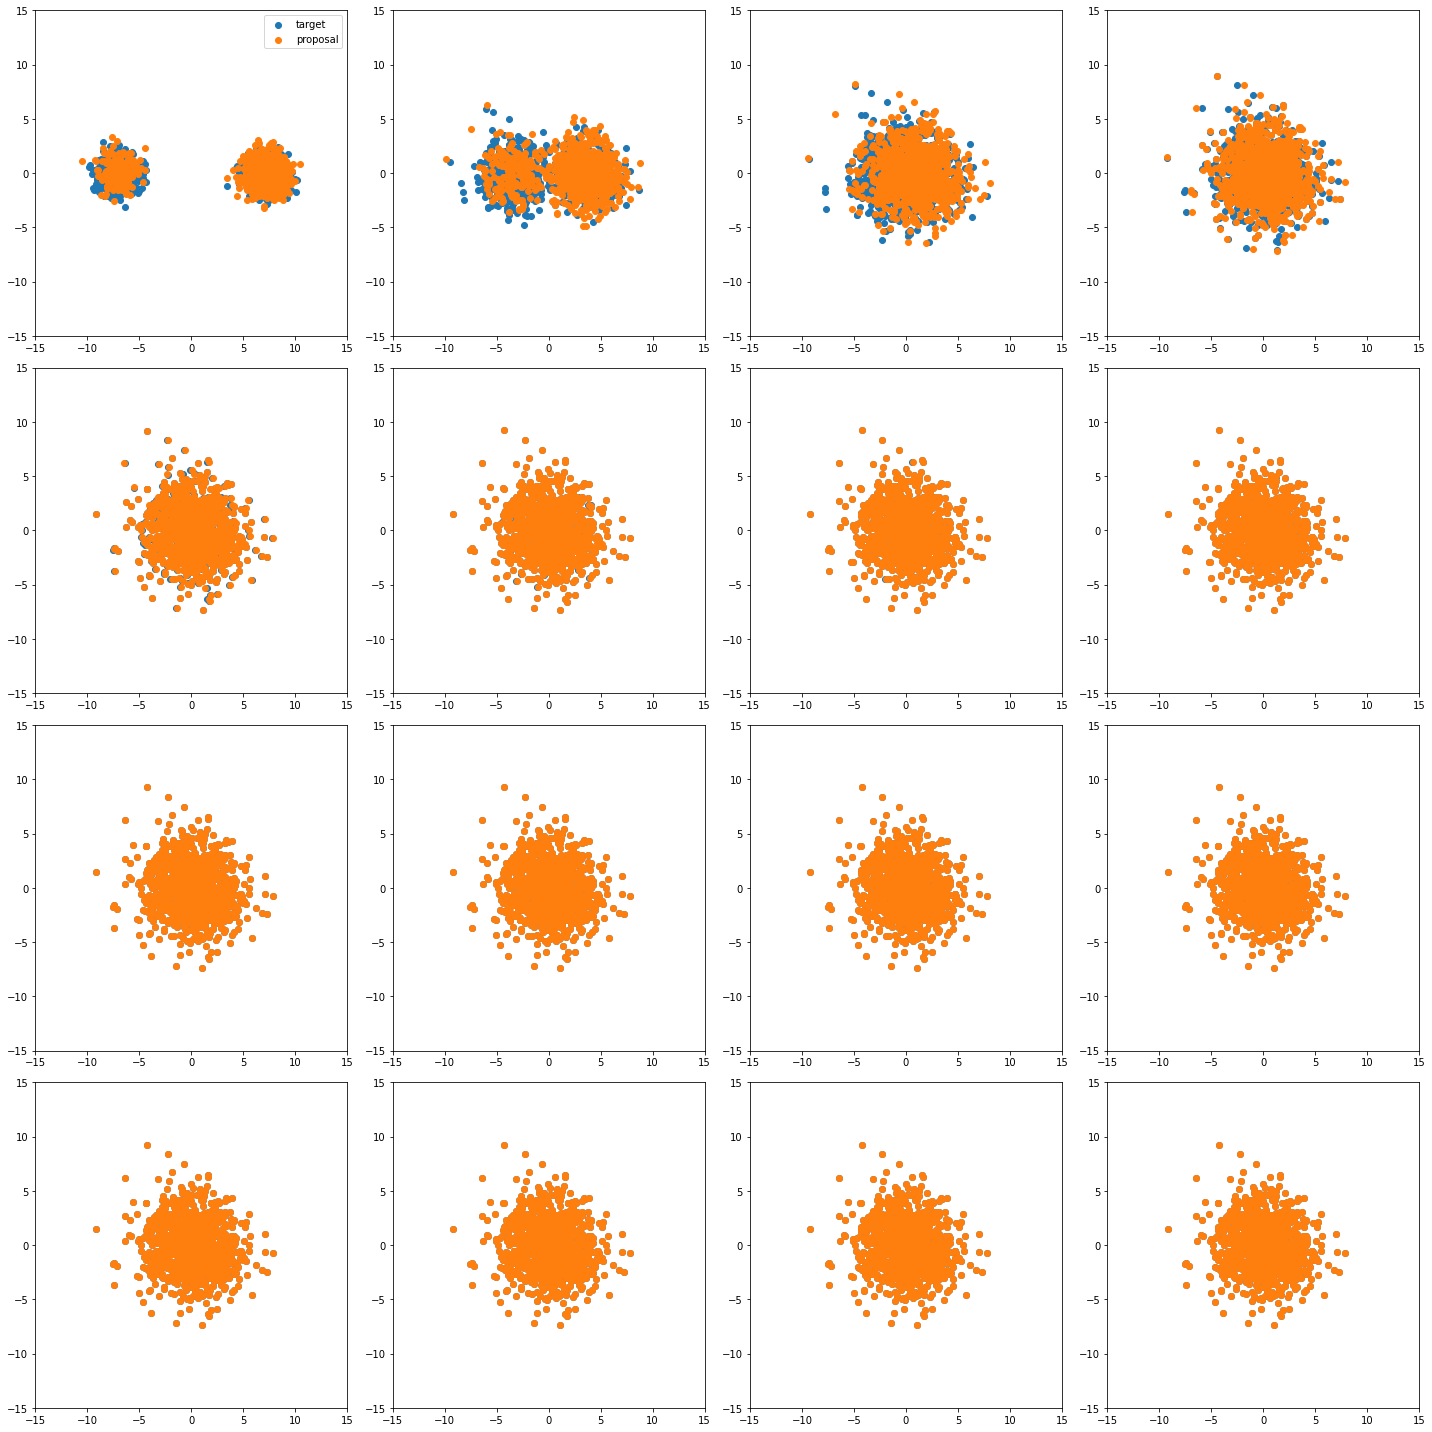

In [8]:
ksd_val = plot_diffused_data(
    beta=0.5,
    target=target,
    target_sample=target_sample,
    proposal_sample=proposal_sample,
    nsteps=16,
    nrows=4,
    ncols=4,
)

X_t = sqrt{beta} * X_{t-1} + \sqrt{1 - beta} * Z_t
X_t = gamma_t * X_0 + alpha_t * Z

e^{-sqrt{beta_t}} * X_0 + sqrt{1 - e^{-2 sqrt{beta}}} * N(0, 1)

p_{X_t}(x) = \int p_{X_0}( (x - alpha_t * z) / gamma_t ) N(z; 0, 1) dz

grad p_{X_t}(x) / p_{X_t}(x)

In [117]:
# check estimation of score function
def estimate_score_fn(X, conv_samples, gamma_t, alpha_t, target, noise_prob_fn, importance_prob_fn):
    X_cp = tf.expand_dims(tf.identity(X), axis=0) # 1 x n x dim

    ## estimate score for convolution
    Z = tf.expand_dims(conv_samples, axis=1) # l x 1 x dim
    Z_1 = X_cp + Z * gamma_t / alpha_t # l x n x dim

    with tf.GradientTape() as g:
        g.watch(X_cp)
        diff_1 = (X_cp - alpha_t * Z) / gamma_t # l x n x dim      
        prob_1 = target.prob(diff_1) # l x n
        den_ratio1 = noise_prob_fn(Z_1) / importance_prob_fn(Z) # l x n
        prob_1 = prob_1 * den_ratio1 # l x n

    grad_1 = g.gradient(prob_1, X_cp) # 1 x n x dim
    grad_1 = tf.squeeze(grad_1, axis=0) # n x dim
    score_X = grad_1 / tf.expand_dims(
      tf.math.reduce_sum(prob_1, axis=0), axis=1) # n x dim
    print("denom", tf.math.reduce_min(tf.math.reduce_sum(prob_1, axis=0)))
    _ = tf.debugging.assert_all_finite(grad_1, "grad_1")
    print("nume", tf.math.reduce_max(grad_1))
    _ = tf.debugging.assert_all_finite(score_X, "score_X")
    return score_X


def true_log_prob_fn(X, ratio, gamma_t, alpha_t):
    means = [tf.constant([-10., 0.]), tf.constant([10., 0.])]
    
    log_ratio1 = tf.math.log(ratio)
    log_ratio2 = tf.math.log(1-ratio)
    
    exp1 = tf.math.reduce_sum((X - means[0]*gamma_t)**2, axis=-1) / (gamma_t**2 + alpha_t**2)
    exp2 = tf.math.reduce_sum((X - means[1]*gamma_t)**2, axis=-1) / (gamma_t**2 + alpha_t**2)
    
    exps = tf.stack([-0.5 * exp1 + log_ratio1, -0.5 * exp2 + log_ratio2]) # 2 x n
    log_prob = tf.math.reduce_logsumexp(exps, axis=0)
    
    return log_prob

def true_score_fn(X, ratio, gamma_t, alpha_t):
    with tf.GradientTape() as g:
        g.watch(X)
        log_prob_1 = true_log_prob_fn(X, ratio, gamma_t, alpha_t) # l x n

    grad_1 = g.gradient(log_prob_1, X) # n x dim
    return grad_1
    

def check_estimated_score_fn(beta, target, X, nsteps, ns, nrows, ncols, ratio):
    # generate noise
    noise_list = []
    for n in ns:
        noise_list.append(tf.random.normal([nsteps, n, X.shape[1]]))
    
    res = []
    figs, axes = plt.subplots(nrows, ncols, figsize=(20, 20))
    for j, t in enumerate(range(nsteps)):
        print(f"[{j} / {nsteps}]")
        
        alpha_t = tf.math.sqrt(beta) * (1 - tf.math.sqrt(1 - beta)**(t+1)) / (1 - tf.math.sqrt(1 - beta))
        gamma_t = tf.math.sqrt(1 - beta)**(t+1)
        
        mse_list = []
        for i, n in enumerate(ns):
            noise = noise_list[i][j]
            estimated_scores = estimate_score_fn(X, noise, gamma_t, alpha_t, target, gaussian_prob, gaussian_prob)
            true_scores = true_score_fn(X, ratio, gamma_t, alpha_t)
            assert estimated_scores.shape == true_scores.shape
            _ = tf.debugging.assert_all_finite(estimated_scores, "estimated_scores")
            _ = tf.debugging.assert_all_finite(true_scores, "true_scores")
            
            mse = tf.math.reduce_sum((estimated_scores - true_scores)**2)
            mse_list.append(mse)
            print(mse_list)
            
        axes[j//ncols][j%ncols].scatter(ns, mse_list)
        
        res.append(mse_list)
        
    plt.tight_layout()
    
    return res

[0 / 20]
denom tf.Tensor(1.399352e-26, shape=(), dtype=float32)
nume tf.Tensor(0.019770566, shape=(), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=2569.5176>]
denom tf.Tensor(7.0280897e-20, shape=(), dtype=float32)
nume tf.Tensor(1.6259804, shape=(), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=2569.5176>, <tf.Tensor: shape=(), dtype=float32, numpy=4060.8845>]
denom tf.Tensor(4.670504e-16, shape=(), dtype=float32)
nume tf.Tensor(152.40501, shape=(), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=2569.5176>, <tf.Tensor: shape=(), dtype=float32, numpy=4060.8845>, <tf.Tensor: shape=(), dtype=float32, numpy=6135.1934>]
denom tf.Tensor(2.0994948e-14, shape=(), dtype=float32)
nume tf.Tensor(1056.1682, shape=(), dtype=float32)
[<tf.Tensor: shape=(), dtype=float32, numpy=2569.5176>, <tf.Tensor: shape=(), dtype=float32, numpy=4060.8845>, <tf.Tensor: shape=(), dtype=float32, numpy=6135.1934>, <tf.Tensor: shape=(), dtype=float32, numpy=5952.1787>]
[1 / 20]


InvalidArgumentError: score_X : Tensor had NaN values [Op:CheckNumerics]

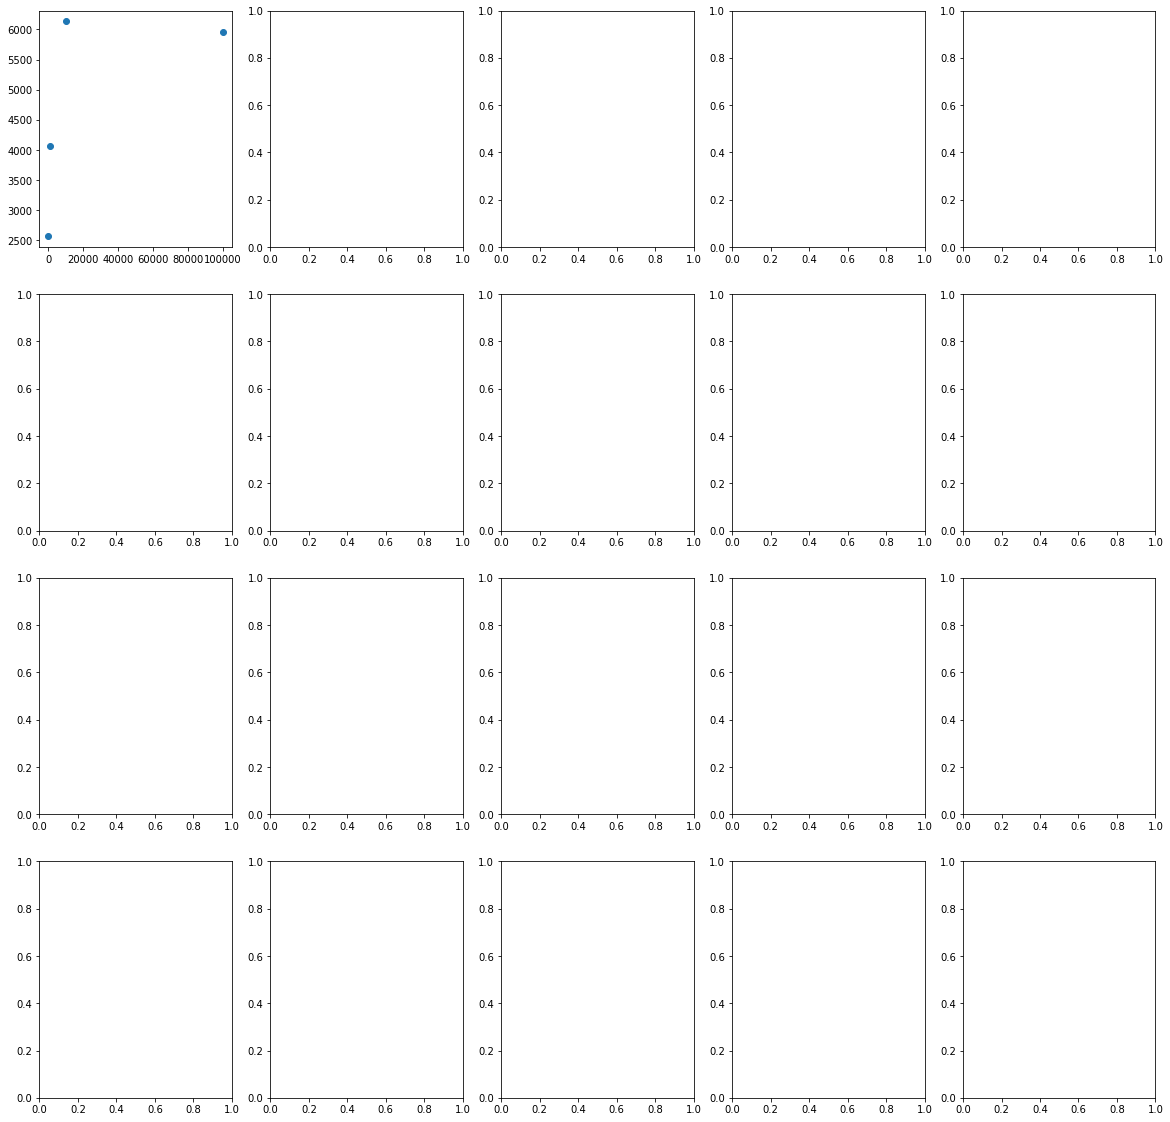

In [118]:
mse_res = check_estimated_score_fn(
    beta=0.2,
    target=target,
    X=target_sample,
    ratio=ratio_target,
    nsteps=20,
    ns=[100, 1000, 10000, 100000],
    nrows=4,
    ncols=5,
)

# Dim augmentation

In [109]:
dim = 1

## mixure of gaussians
k = 1
delta = 10.
shift = - delta / 2
ratio_sample = 1.
ratio_target = 0.5

target, log_prob_fn = models.create_mixture_gaussian_kdim(
    dim=dim, k=k, delta=delta, shift=shift, return_logprob=True, ratio=ratio_target)
proposal_off, log_prob_off_fn = models.create_mixture_gaussian_kdim(
    dim=dim, k=k, delta=delta, shift=shift, return_logprob=True, ratio=ratio_sample)


In [110]:
target_sample = target.sample(1000)
proposal_sample = proposal_off.sample(1000)

In [111]:
def make_log_prob_augmented(alpha_t, gamma_t):
    
    def log_prob_augmented(x_tilde):
        # assuming dim = 2
        x = x_tilde[:, :1]
        z = x_tilde[:, 1:]

        logp_cond = - 0.5 / alpha_t**2 * (z - gamma_t*x)**2
        logp_cond = tf.reshape(logp_cond, (-1, ))
        logp = target.log_prob(x)
        logp_aug = logp_cond + logp
        return logp_aug
    
    return log_prob_augmented

In [112]:
# log_prob_augmented = make_log_prob_augmented(0.5, 0.2)
# log_prob_augmented(tf.concat([proposal_sample, proposal_sample], axis=1)).shape

In [137]:
def plot_diffused_augmented_data(beta, target, target_sample, proposal_sample, nsteps, nrows, ncols):
    noise = tf.random.normal([nsteps] + target_sample.shape)
    samples = [target_sample, proposal_sample]
    labels = ["target", "proposal"]
    
    # compute raw KSD
    kernel = IMQ(med_heuristic=True)
    ksd = KSD(target=target, kernel=kernel)
    ksd_val = ksd(X=proposal_sample, Y=tf.identity(proposal_sample))
    ksd_val = np.round(ksd_val, 3)
    print("raw KSD:", ksd_val)
    
    for j, t in enumerate(range(nsteps)):

        alpha_t = tf.math.sqrt(beta) * (1 - tf.math.sqrt(1 - beta)**(t+1)) / (1 - tf.math.sqrt(1 - beta))
        gamma_t = tf.math.sqrt(1 - beta)**(t+1)
        samples_p = []
        ksd_vals = []
        gksd_vals = []
        for i, x in enumerate(samples):
            label = labels[i]
            x_p = gamma_t * x + alpha_t * noise[t]
            x_aug = tf.concat([x, x_p], axis=1)

            samples_p.append(x_aug)

            # ksd between perturbed distributions
            log_prob_augmented = make_log_prob_augmented(alpha_t, gamma_t)
            kernel = IMQ(med_heuristic=True)
            ksd = KSD(log_prob=log_prob_augmented, kernel=kernel)
            ksd_val = ksd(X=x_aug, Y=tf.identity(x_aug))
            ksd_val = np.round(ksd_val, 3)
            ksd_vals.append(ksd_val)
            
            # GKSD in some projected space
            A = tf.eye(2)[1:]
            kernel = IMQ(med_heuristic=True)
            gksd = GKSD(log_prob=log_prob_augmented, kernel=kernel, A=A)
            gksd_val = gksd(X=x_aug, Y=tf.identity(x_aug))
            gksd_val = np.round(gksd_val, 3)
            gksd_vals.append(gksd_val)
            
            
        plot_data = tf.concat(samples_p, axis=0)
        plot_data = pd.DataFrame(
            {
                "x1": plot_data[:, 0],
                "x2": plot_data[:, 1],
                "type": ["target"] * samples_p[0].shape[0] + ["proposal"] * samples_p[1].shape[0],
            },
        )
        sns.jointplot(data=plot_data, x="x1", y="x2", hue="type", xlim=[-15, 15], ylim=[-15, 15], height=4)
        
#         print(f"KSD: \tH0: {ksd_vals[0]}, \tH1: {ksd_vals[1]}")
        print(f"GKSD: \tH0: {gksd_vals[0]}, \tH1: {gksd_vals[1]}")

    plt.tight_layout()

raw KSD: 0.001
GKSD: 	H0: 0.004000000189989805, 	H1: 0.004000000189989805
GKSD: 	H0: 0.0010000000474974513, 	H1: 0.0010000000474974513
GKSD: 	H0: 0.0, 	H1: 0.0
GKSD: 	H0: 0.0020000000949949026, 	H1: 0.0020000000949949026
GKSD: 	H0: 0.0, 	H1: 0.0
GKSD: 	H0: 0.0, 	H1: 0.0
GKSD: 	H0: 0.0, 	H1: 0.0
GKSD: 	H0: 0.0, 	H1: 0.0
GKSD: 	H0: 0.0010000000474974513, 	H1: 0.0010000000474974513
GKSD: 	H0: 0.0, 	H1: 0.0
GKSD: 	H0: 0.0, 	H1: 0.0
GKSD: 	H0: 0.0, 	H1: 0.0
GKSD: 	H0: 0.0, 	H1: 0.0
GKSD: 	H0: 0.0, 	H1: 0.0
GKSD: 	H0: 0.0, 	H1: 0.0
GKSD: 	H0: 0.0, 	H1: 0.0


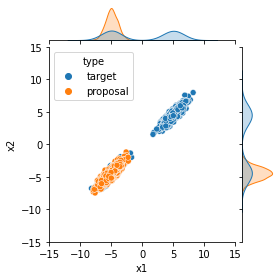

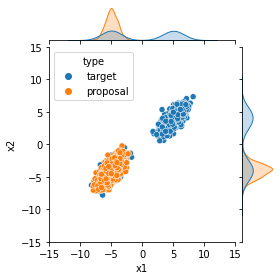

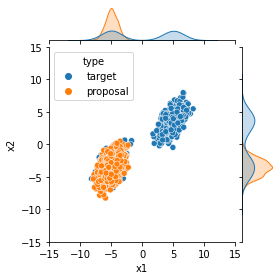

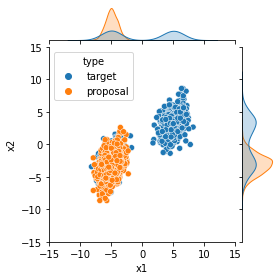

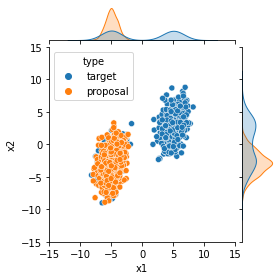

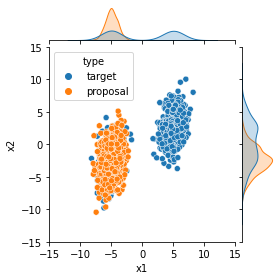

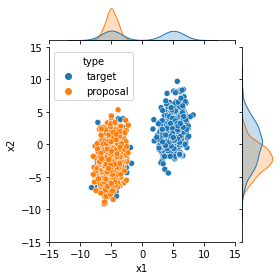

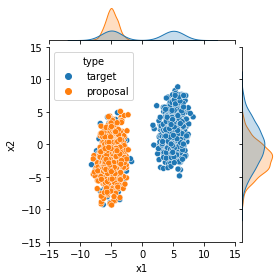

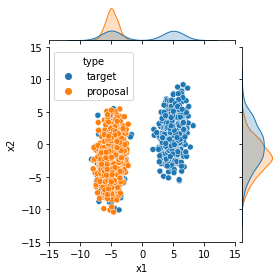

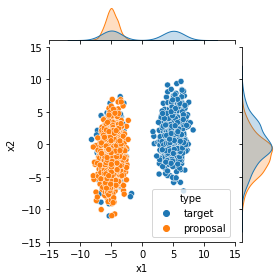

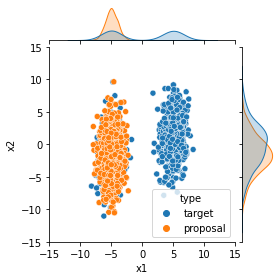

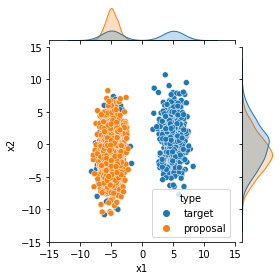

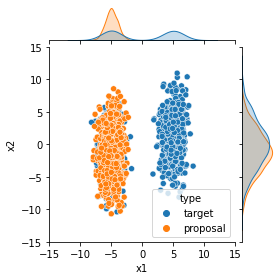

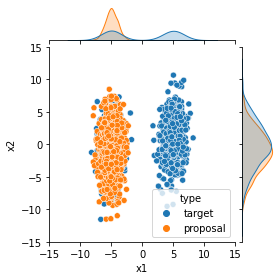

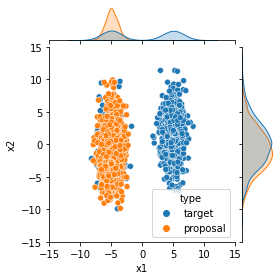

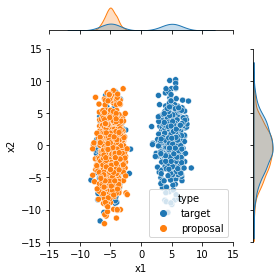

In [138]:
ksd_val = plot_diffused_augmented_data(
    beta=0.2,
    target=target,
    target_sample=target_sample,
    proposal_sample=proposal_sample,
    nsteps=16,
    nrows=4,
    ncols=4,
)

In [143]:
def plot_score_augment(beta, target, target_sample, proposal_sample, nsteps, nrows, ncols):
    noise = tf.random.normal([nsteps] + target_sample.shape)
    samples = [target_sample, proposal_sample]
    labels = ["target", "proposal"]

    figs, axes = plt.subplots(nrows, ncols, figsize=(20, 20))
    for j, t in enumerate(range(nsteps)):

        alpha_t = tf.math.sqrt(beta) * (1 - tf.math.sqrt(1 - beta)**(t+1)) / (1 - tf.math.sqrt(1 - beta))
        gamma_t = tf.math.sqrt(1 - beta)**(t+1)
        samples_p = []
        for i, x in enumerate(samples):
            label = labels[i]
            x_p = gamma_t * x + alpha_t * noise[t]
            x_aug = tf.concat([x, x_p], axis=1)

            samples_p.append(x_aug)

            # score function
            log_prob_augmented = make_log_prob_augmented(alpha_t, gamma_t)
            with tf.GradientTape() as g:
                g.watch(x_aug)
                log_prob_X = log_prob_augmented(x_aug)
            
            # score function projected by A
            A = tf.eye(2)[1:]
#             A = tf.eye(2)[:1]
            score_X = g.gradient(log_prob_X, x_aug) # n x d_aug
            A_score_X = tf.linalg.matmul(score_X, A, transpose_b=True) # n x 1
            
            axes[j//ncols][j%ncols].scatter(x_aug[:, 1], A_score_X, label=label)
            axes[j//ncols][j%ncols].set_xlim(-15, 15)
            
    axes[0][0].legend()
    plt.tight_layout()

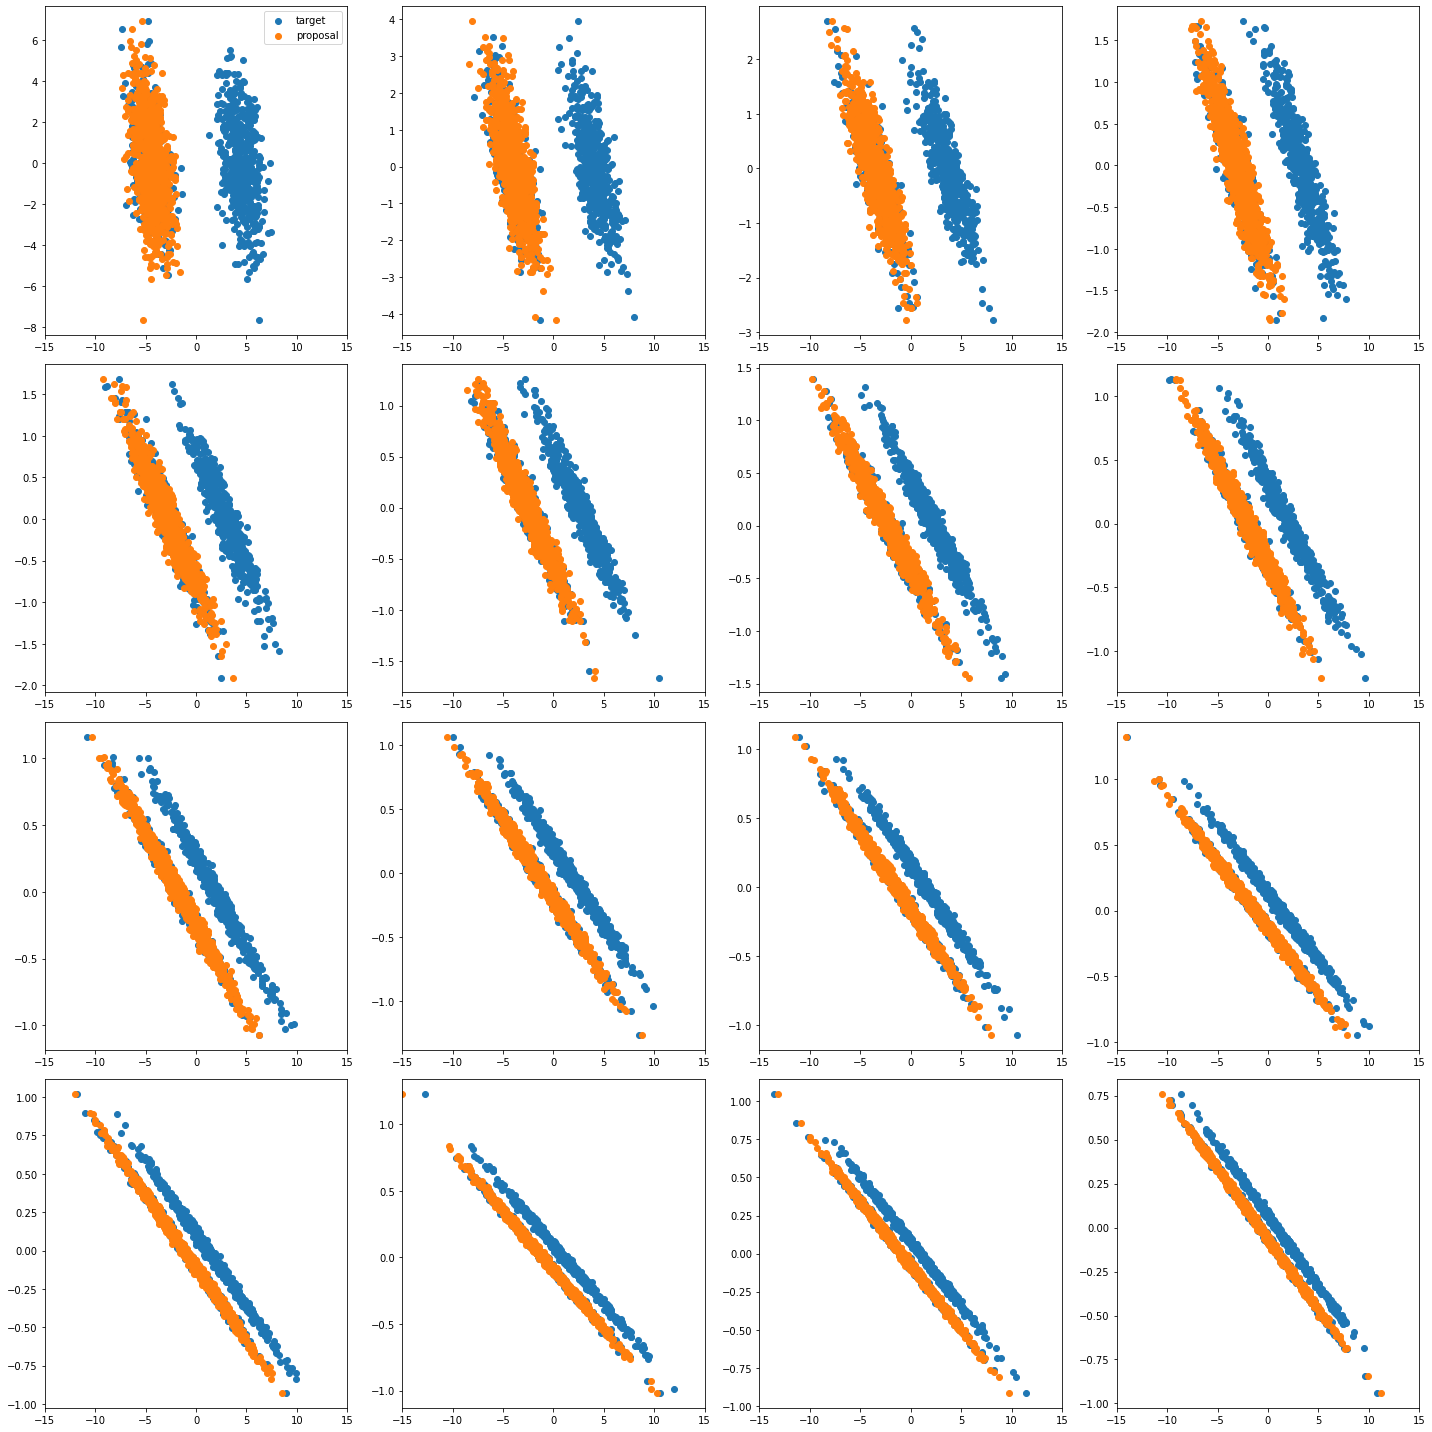

In [144]:
ksd_val = plot_score_augment(
    beta=0.2,
    target=target,
    target_sample=target_sample,
    proposal_sample=proposal_sample,
    nsteps=16,
    nrows=4,
    ncols=4,
)